In [1]:
import numpy as np
import matplotlib.pyplot as plt
from finite_volume.advection import AdvectionSolver
from finite_volume.initial_conditions import generate_ic


def l1(x: np.ndarray) -> float:
    return np.mean(np.abs(x))


def l2(x: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(x)))


def linf(x: np.ndarray) -> float:
    return np.max(np.abs(x))

In [2]:
p = 2
n_rotations = 2
quadrature = "gauss-legendre"
ic_type__PAD = "square", (-np.inf, np.inf)
limiter_config = dict(
    aposteriori_limiting=True,
    SED=True,
    hancock=False,
    convex=False,
    fallback_to_first_order=False,
    fallback_limiter="minmod",
)

In [3]:
ic_type, PAD = ic_type__PAD


def rotate(x, n):
    return np.fliplr(x)
    return np.rot90(np.flipud(x), -n)


def u0(x, y):
    return generate_ic(type=ic_type, x=x, y=y)


def u0_rotated(x, y):
    return u0(x, y)
    return rotate(u0(x, y), n=n_rotations)


u0_rotated.__name__ += f"_{n_rotations}"

vx_vy = (1, 0)
vx_vy_C4 = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}

shared_config = dict(
    **limiter_config,
    save=False,
    load=False,
    PAD=PAD,
    NAD=1e-5,
    n=(40,),
    order=p + 1,
    flux_strategy=quadrature,
    courant=0.8,
    snapshot_dt=0.02,
    num_snapshots=50,
)

# baseline
solver = AdvectionSolver(
    **shared_config,
    u0=u0,
    v=vx_vy,
)
solver.rkorder()
# solver.one_euler_step()

# reflected
solver_rotated = AdvectionSolver(
    **shared_config,
    u0=u0_rotated,
    v=vx_vy_C4[n_rotations],
)
solver_rotated.rkorder()
# solver_rotated.one_euler_step()


inner = solver_rotated.u_snapshots[-1][1]
outer = rotate(solver.u_snapshots[-1][1], n=n_rotations)
# outer = solver.u_snapshots[-1][1].T
# check equivariance
diffs = inner - outer
# diffs = solver.u_snapshots[-1][1] - np.flipud(np.rot90(np.flipud(solver_rotated.u_snapshots[-1][1]), k=-n_rotations))

print(np.mean(np.abs(solver.u_snapshots[-1][1] - solver.u_snapshots[-1][1])))

print(f"{l1(diffs)=}")
print(f"{l2(diffs)=}")
print(f"{linf(diffs)=}")

np.set_printoptions(precision=2)

New solution instance...


  0%|          | 0/1.0 [00:00]

 98%|█████████▊| 0.9800000000000005/1.0 [00:09] /usr/local/Caskroom/miniconda/base/envs/fv-env/lib/python3.11/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000004/1.0 [00:09]



New solution instance...


100%|██████████| 1.0000000000000004/1.0 [00:00] 


0.0
l1(diffs)=0.0005163279983645075
l2(diffs)=0.0018944299145611286
linf(diffs)=0.017441437221733747


In [4]:
np.mean(np.abs(solver.u_snapshots[-2][1] - solver.uold))

0.0

In [5]:
np.where(np.abs(solver.uold - np.rot90(solver_rotated.uold, -1, axes=(1, 0))) > 1e-10)
rotate()

TypeError: rotate() missing 2 required positional arguments: 'x' and 'n'

In [ ]:
np.where(
    np.abs(solver.north_face - np.rot90(solver_rotated.west_face, -1, axes=(1, 0)))
    > 1e-10
)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18,
        18, 

In [ ]:
np.where(
    np.abs(
        solver.fallback_fluxes_x
        - np.rot90(solver_rotated.fallback_fluxes_y, -1, axes=(1, 0))
    )
    > 1e-10
)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 

In [ ]:
np.where(np.abs(solver.trub - np.rot90(solver_rotated.trub, -1, axes=(1, 0))) > 0)

(array([13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18,
        18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21,
        21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,
        23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
        26, 26, 26]),
 array([26, 27, 34,  4, 34, 35, 36,  3,  5,  6,  7, 14, 15, 24, 25, 27, 34,
        35, 36, 14, 15, 23, 26, 27, 36,  3,  6,  7,  8, 14, 15, 16,  4,  5,
        14, 15, 16, 36,  6, 26, 27, 34, 35, 36,  6, 26, 27, 34, 35, 36,  4,
         5, 14, 15, 16, 36,  3,  6,  7,  8, 14, 15, 16, 14, 15, 23, 26, 27,
        36,  3,  5,  6,  7, 14, 15, 24, 25, 27, 34, 35, 36,  4, 34, 35, 36,
        26, 27, 34]))

In [ ]:
np.where(np.abs(solver.alpha - np.rot90(solver_rotated.alpha, -1, axes=(1, 0))) > 1e-10)

(array([12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15,
        16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 19, 20, 21, 21, 22, 22, 23,
        23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26,
        26, 26, 27, 27, 27]),
 array([ 7,  8, 24,  4,  5,  7,  9, 23, 24,  2, 32, 33, 38, 39, 12, 32, 33,
         7, 19, 26, 28, 32, 33, 26, 34, 12, 13,  6,  6, 12, 13, 26, 34,  7,
        19, 26, 28, 32, 33, 12, 32, 33,  2, 32, 33, 38, 39,  4,  5,  7,  9,
        23, 24,  7,  8, 24]))

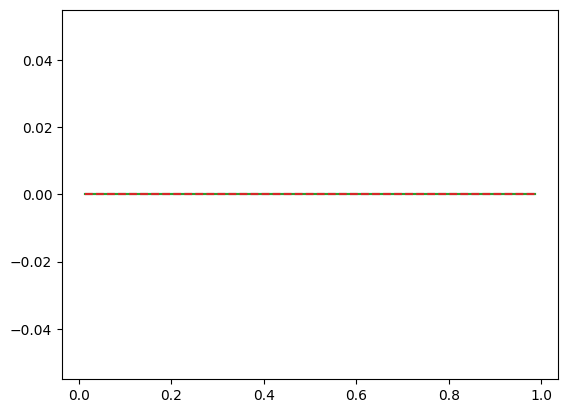

In [ ]:
i = 30
plt.plot(solver.x, solver.u_snapshots[-1][1][i, :])
plt.plot(solver_rotated.x, solver_rotated.u_snapshots[-1][1][:, i], "--")
plt.plot(solver.x, solver.alpha[i, :])
plt.plot(solver_rotated.x, solver_rotated.alpha[:, i], "--")

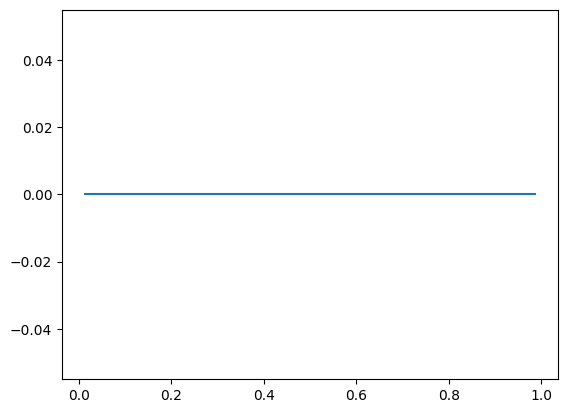

In [ ]:
plt.plot(
    solver.x, solver.u_snapshots[-1][1][i, :] - solver_rotated.u_snapshots[-1][1][:, i]
)

In [ ]:
np.where(
    np.abs(solver.NAD_trouble - np.rot90(solver_rotated.NAD_trouble, -1, axes=(1, 0)))
    > 0
)

(array([13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18,
        18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21,
        21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26,
        26]),
 array([26, 27, 34,  4, 34, 35, 36,  3,  5,  6,  7, 14, 15, 24, 25, 27, 34,
        35, 36, 14, 15, 23, 26, 27, 36,  3,  6,  7,  8, 14, 15, 16,  4,  5,
        14, 15, 16, 36, 26, 27, 34, 35, 36, 26, 27, 34, 35, 36,  4,  5, 14,
        15, 16, 36,  3,  6,  7,  8, 14, 15, 16, 14, 15, 23, 26, 27, 36,  3,
         5,  6,  7, 14, 15, 24, 25, 27, 34, 35, 36,  4, 34, 35, 36, 26, 27,
        34]))

In [ ]:
np.where(np.abs(solver.dudt - np.rot90(solver_rotated.dudt, -1, axes=(1, 0))) > 1e-10)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 

In [ ]:
np.where(np.abs(solver.unew0 - np.rot90(solver_rotated.unew0, -1, axes=(1, 0))) > 1e-10)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 

In [ ]:
np.where(np.abs(solver.unew - np.rot90(solver_rotated.unew, -1, axes=(1, 0))) > 1e-10)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 

In [ ]:
np.where(
    np.abs(
        solver.troubled_interface_mask_x
        - np.rot90(solver_rotated.troubled_interface_mask_y, -1, axes=(1, 0))
    )
    > 0
)

(array([13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 20, 20,
        20, 20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26]),
 array([26, 28, 34, 35,  4, 34, 36,  8, 14, 15, 16, 24, 26, 27, 28, 34, 35,
        36, 14, 26, 28, 36,  6,  9, 14, 14, 36,  6,  7, 26, 28, 34,  6,  7,
        26, 28, 34, 14, 36,  6,  9, 14, 14, 26, 28, 36,  8, 14, 15, 16, 24,
        26, 27, 28, 34, 35, 36,  4, 34, 36, 26, 28, 34, 35]))

In [ ]:
np.where(
    np.abs(solver.fold_ho - np.rot90(solver_rotated.gold_ho, -1, axes=(1, 0))) > 1e-10
)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 

In [ ]:
np.where(np.abs(solver.fold - np.rot90(solver_rotated.gold, -1, axes=(1, 0))) > 1e-10)

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 

In [ ]:
np.where(
    np.abs(solver.u_snapshots[-1][1] - solver_rotated.u_snapshots[-1][1].T) > 1e-10
)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
print(solver.all_simulation_times)
print(solver_rotated.all_simulation_times)

[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000001, 0.14, 0.16, 0.18, 0.19999999999999998, 0.21999999999999997, 0.23999999999999996, 0.25999999999999995, 0.27999999999999997, 0.3, 0.32, 0.34, 0.36000000000000004, 0.38000000000000006, 0.4000000000000001, 0.4200000000000001, 0.4400000000000001, 0.46000000000000013, 0.48000000000000015, 0.5000000000000001, 0.5200000000000001, 0.5400000000000001, 0.5600000000000002, 0.5800000000000002, 0.6000000000000002, 0.6200000000000002, 0.6400000000000002, 0.6600000000000003, 0.6800000000000003, 0.7000000000000003, 0.7200000000000003, 0.7400000000000003, 0.7600000000000003, 0.7800000000000004, 0.8000000000000004, 0.8200000000000004, 0.8400000000000004, 0.8600000000000004, 0.8800000000000004, 0.9000000000000005, 0.9200000000000005, 0.9400000000000005, 0.9600000000000005, 0.9800000000000005, 1.0000000000000004]
[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000001, 0.14, 0.16, 0.18, 0.19999999999999998, 0.21999999999999997, 0.23999999999999996, 0.25999

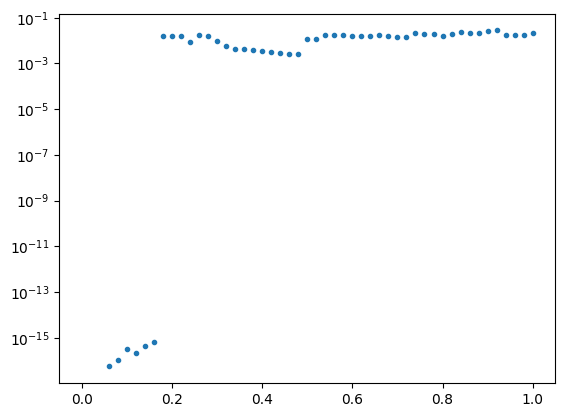

In [ ]:
ts = [x[0] for x in solver.u_snapshots]
diffs = [
    np.max(np.abs(np.rot90(x[1], axes=(1, 0)) - y[1]))
    for x, y in zip(solver.u_snapshots, solver_rotated.u_snapshots)
]

plt.plot(ts, diffs, ".")
plt.yscale("log")